In [51]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
mpl.style.available
mpl.style.use('ggplot') 
from IPython.display import display, HTML
from itertools import cycle, islice
from matplotlib.font_manager import FontProperties
from ipywidgets import widgets
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from bokeh.plotting import figure, output_file, show
import datetime as dt 
from IPython.display import clear_output
import sklearn

from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_selection import RFE
from time import time
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix
import itertools

In [53]:
def fit_and_score_clf(clf, X, y, n_cv):

    accuracy = cross_val_score(clf, X, y, cv=n_cv,n_jobs=-1)
    precision = cross_val_score(clf, X, y, cv=n_cv, scoring='precision',n_jobs=-1)
    recall = cross_val_score(clf, X, y, cv=n_cv, scoring='recall',n_jobs=-1)

    fitted_clfs.append(clf)
    

    print('Report for', clf.__class__.__name__)
    print('')
    print('accuracy: ', accuracy.mean())
    print('precision: ', precision.mean())
    print('recall: ', recall.mean())
    print('')
    
    return clf, accuracy.mean(), precision.mean(), recall.mean()

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [90]:
def perform_recusive_feature_eval(clf, X, y, features):
    
    start = time()
    
    rfecv = RFECV(estimator=clf, step=1, scoring='recall', n_jobs=-1)
    rfecv = rfecv.fit(X,y)
    
    print('RFECV ran in ', time() - start, 'secs for '+clf.__class__.__name__)
    print("")
    print("Optimal number of features : %d" % rfecv.n_features_)
    print("")
    print("Supporting features: ")
    print("")
    support_features = []
    
    for i in range(len(rfecv.support_)):
    
        if(rfecv.support_[i]):
            
            print(features[i])
            
            support_features.append(features[i])
            
    
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (recall)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()        
    
    return support_features

In [81]:
def random_forest_feature_importance(forest,X,y,features):

    forest.fit(X, y)
    importances = forest.feature_importances_

    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    
    important_features = []

    for f in range(X.shape[1]):
        print(str(f+1)+'. '+features[indices[f]]+' '+str(importances[indices[f]]))
        
        important_features.append(features[indices[f]])

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
    
    
    return important_features

## Load data

In [114]:
df = pd.read_pickle("./customer_df_with_engineered_features.pkl")
df.fillna(0,inplace = True)

## First run through classifiers with no optimization (feature or parameters)

Pick some classifiers to test

Report for LogisticRegression

accuracy:  0.714438844627
precision:  0.665314281493
recall:  0.811203318041

Normalized confusion matrix
[[ 0.63  0.37]
 [ 0.19  0.81]]


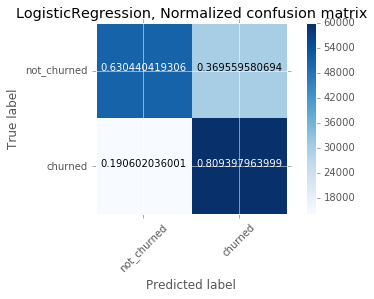

Report for RandomForestClassifier

accuracy:  0.745370273779
precision:  0.710503161829
recall:  0.789494141782



In [ ]:
##  Logisitic regression, linear SVM, random forest
clfs = [LogisticRegression(), LinearSVC(tol = 0.01), RandomForestClassifier(max_depth=10, n_estimators=100)]

clfs = [LogisticRegression(),RandomForestClassifier(max_depth=10)]

#Loop through each classifier and cross-validate, check accuracy, precision and recall

y = df.churn_label

y = np.ravel(y)

## Drop non-feature columns
X = df.drop(
    ['customer_id', 'churn_label', 'gender', 'country', 'date_created',
       'YOB', 'premier', 'account_age', 'account_age_months','rounded_total_spent'], axis = 1)

features = X.columns

# Scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)

accuracy_l = []
precision_l = []
recall_l = []

#Cycle through classifiers

for clf in clfs:
    
    clf_name = clf.__class__.__name__
    
    fitted_clf, accuracy, precision, recall = fit_and_score_clf(clf, X, y, 5)
    
    accuracy_l.append((clf_name, accuracy))
    precision_l.append((clf_name, precision))
    recall_l.append((clf_name, recall))
    
    ## Plot confusion matrix

    class_names = ['not_churned','churned']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    y_pred = clf.fit(X_train, y_train).predict(X_test)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title=clf.__class__.__name__+', Normalized confusion matrix')

    plt.show()
    
print('Accuracy rankings: ')
print(sorted(accuracy_l, key=lambda tup: tup[1]))

print('Precision rankings: ')
print(sorted(precision_l, key=lambda tup: tup[1]))

print('Recall rankings: ')
print(sorted(recall_l, key=lambda tup: tup[1]))

## Optimize features for recall

We want to maximise recall, misclassifying a customer as churning when they won't churn is okay. Misclassifying a churning customer as not churning means we lose a customer.

In [ ]:
support_features_l = []

#perform recursive feature evaluation for Logistic regression and SVM using recall as a score
for clf in clfs[:1]:
    
    support_features = perform_recusive_feature_eval(LogisticRegression(), X, y, features)
    
    support_features_l.append((clf_name,support_features))

##Plot random forest feature importance
importance_sorted_features = \
    random_forest_feature_importance(clfs[1],X,y,features)

##take top 10
support_features_l.append((clf_name,importance_sorted_features[:10]))

## Retest with optimized features

In [ ]:
for i in range(len(clfs)):

    ## Drop non-feature columns
    X = df[support_features_l[i][1]]

    # Scale data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    clf = clfs[i]
    
    fitted_clf, accuracy, precision, recall = fit_and_score_clf(clf, X, y, 5)